# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [18]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.72KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

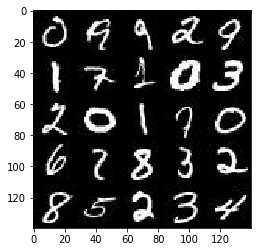

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

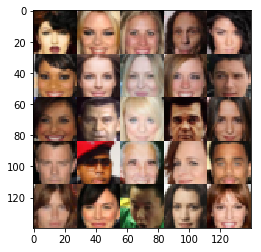

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_img_inputs = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name="real_img_inputs")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    lr = tf.placeholder(tf.float32, name="lr")
    
    return real_img_inputs,z_inputs,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [53]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28xoutput_dim
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1*0.2)
        #14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*0.2)
        # 7x7x256
        
        # 4x4x512
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*0.2)
        
        # remove one layer from discriminator
#         # 2x2x1024
#         x4 = tf.layers.conv2d(x3, 1024, 5, strides=2, padding='same')
#         x4 = tf.layers.batch_normalization(x4, training=True)
#         x4 = tf.maximum(x4, x4*0.2)
    
        # flatten
        x4 = tf.reshape(x3, (-1,4*4*512))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [44]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z,2*2*512)
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        #print(x1.shape)
        
        # 7x7x256
        x2 = tf.layers.conv2d_transpose(x1,256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        #print(x2.shape)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(x2,128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        #print(x3.shape)
        
        # 28x28xout
        x4 = tf.layers.conv2d_transpose(x3,out_channel_dim, 5, strides=2, padding='same')
        #print(x4.shape)
        
        out = tf.tanh(x4)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [45]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # get the logits
    gen_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(images=gen_out, reuse=True)
    
    
    # loss calculations
    smooth = 0.05
    labels_real = tf.ones_like(d_out_real) * (1 - smooth)
    labels_fake = tf.zeros_like(d_out_fake)
    labels_generator = tf.ones_like(d_out_fake)
    # discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_generator))
    

    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_trainable_vars = tf.trainable_variables()
    g_vars = [var for var in all_trainable_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_trainable_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    img_channels_count = data_shape[3]
    
    print("Image size ",img_width,"x",img_height,"x",img_channels_count)
    # build model 
    real_img_inputs, z_inputs, lr = model_inputs(img_width, img_height, img_channels_count, z_dim)
    d_loss, g_loss = model_loss(real_img_inputs, z_inputs, img_channels_count)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # because RGB value is in range of -0.5 to 0.5 while tanh is in range -1 to 1
                # need to adjust batch_images value here
                batch_images = batch_images * 2

                # generate random noise 
                batch_z = np.random.uniform(-1,1, size=(batch_size,z_dim))
               
                # train discriminator and generator together
                _ = sess.run(d_train_opt, feed_dict={real_img_inputs:batch_images, z_inputs:batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                # now print loss every 100 iteration
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_inputs:batch_z,real_img_inputs:batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})
                    
                    print("Epoch ",epoch_i,
                          " ... Discri.Loss: ", train_loss_d, 
                          " Generator loss: ", train_loss_g )
                if steps % 100 == 0:    
                    show_generator_output(sess, 16, z_inputs, img_channels_count, data_image_mode)
        
        saver.save(sess, './saved_data.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Image size  28 x 28 x 1
Epoch  0  ... Discri.Loss:  2.43998  Generator loss:  0.183792


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Image size  28 x 28 x 3
Epoch  0  ... Discri.Loss:  1.23223  Generator loss:  7.57803
Epoch  0  ... Discri.Loss:  0.974  Generator loss:  10.6973
Epoch  0  ... Discri.Loss:  1.46752  Generator loss:  4.53969
Epoch  0  ... Discri.Loss:  4.78543  Generator loss:  0.0331691
Epoch  0  ... Discri.Loss:  1.55133  Generator loss:  6.40404
Epoch  0  ... Discri.Loss:  1.46308  Generator loss:  0.855045
Epoch  0  ... Discri.Loss:  1.39972  Generator loss:  1.3109
Epoch  0  ... Discri.Loss:  1.52436  Generator loss:  0.77292
Epoch  0  ... Discri.Loss:  1.44902  Generator loss:  1.5299
Epoch  0  ... Discri.Loss:  0.972861  Generator loss:  2.80778


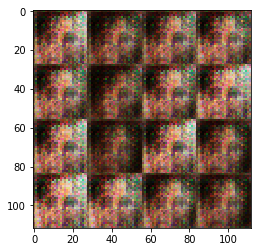

Epoch  0  ... Discri.Loss:  1.54573  Generator loss:  0.880365
Epoch  0  ... Discri.Loss:  1.71705  Generator loss:  0.619141
Epoch  0  ... Discri.Loss:  1.17458  Generator loss:  0.955468
Epoch  0  ... Discri.Loss:  1.46349  Generator loss:  0.973644
Epoch  0  ... Discri.Loss:  1.90221  Generator loss:  0.590895
Epoch  0  ... Discri.Loss:  2.22181  Generator loss:  0.643305
Epoch  0  ... Discri.Loss:  2.11537  Generator loss:  0.627074
Epoch  0  ... Discri.Loss:  1.50803  Generator loss:  0.812277
Epoch  0  ... Discri.Loss:  1.45623  Generator loss:  0.700678
Epoch  0  ... Discri.Loss:  1.15929  Generator loss:  1.27126


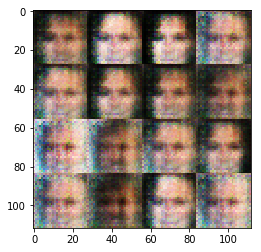

Epoch  0  ... Discri.Loss:  1.37566  Generator loss:  0.769509
Epoch  0  ... Discri.Loss:  1.46908  Generator loss:  0.873372
Epoch  0  ... Discri.Loss:  1.52627  Generator loss:  0.66491
Epoch  0  ... Discri.Loss:  1.41069  Generator loss:  0.854367
Epoch  0  ... Discri.Loss:  1.56501  Generator loss:  0.511579
Epoch  0  ... Discri.Loss:  1.53917  Generator loss:  0.990772
Epoch  0  ... Discri.Loss:  1.82641  Generator loss:  0.69394
Epoch  0  ... Discri.Loss:  1.79948  Generator loss:  0.969869
Epoch  0  ... Discri.Loss:  1.30094  Generator loss:  1.17135
Epoch  0  ... Discri.Loss:  1.37413  Generator loss:  0.985657


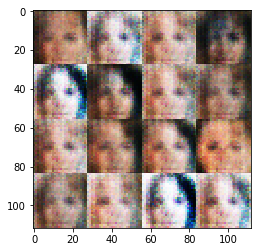

Epoch  0  ... Discri.Loss:  1.1881  Generator loss:  0.913357
Epoch  0  ... Discri.Loss:  1.86557  Generator loss:  0.609481
Epoch  0  ... Discri.Loss:  1.35579  Generator loss:  0.906561
Epoch  0  ... Discri.Loss:  1.12748  Generator loss:  1.02756
Epoch  0  ... Discri.Loss:  1.62497  Generator loss:  0.752035
Epoch  0  ... Discri.Loss:  1.27558  Generator loss:  0.86901
Epoch  0  ... Discri.Loss:  1.26827  Generator loss:  1.18396
Epoch  0  ... Discri.Loss:  1.36371  Generator loss:  0.937341
Epoch  0  ... Discri.Loss:  1.50487  Generator loss:  0.913226
Epoch  0  ... Discri.Loss:  1.48686  Generator loss:  0.828477


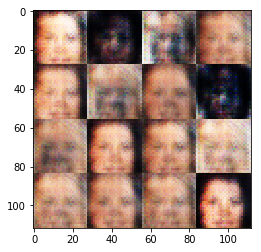

Epoch  0  ... Discri.Loss:  1.60377  Generator loss:  0.661959
Epoch  0  ... Discri.Loss:  1.21228  Generator loss:  0.932104
Epoch  0  ... Discri.Loss:  1.55658  Generator loss:  0.633154
Epoch  0  ... Discri.Loss:  1.14802  Generator loss:  0.855668
Epoch  0  ... Discri.Loss:  1.20426  Generator loss:  0.864663
Epoch  0  ... Discri.Loss:  1.45408  Generator loss:  0.72676
Epoch  0  ... Discri.Loss:  1.51887  Generator loss:  0.753874
Epoch  0  ... Discri.Loss:  1.17308  Generator loss:  0.93315
Epoch  0  ... Discri.Loss:  1.22789  Generator loss:  1.25719
Epoch  0  ... Discri.Loss:  1.44794  Generator loss:  0.789736


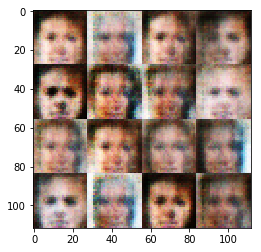

Epoch  0  ... Discri.Loss:  1.39402  Generator loss:  0.808488
Epoch  0  ... Discri.Loss:  1.23211  Generator loss:  0.961121
Epoch  0  ... Discri.Loss:  1.35427  Generator loss:  1.11583
Epoch  0  ... Discri.Loss:  1.4223  Generator loss:  0.7884
Epoch  0  ... Discri.Loss:  1.49508  Generator loss:  0.894304
Epoch  0  ... Discri.Loss:  1.52612  Generator loss:  0.603357
Epoch  0  ... Discri.Loss:  1.72122  Generator loss:  0.564637
Epoch  0  ... Discri.Loss:  1.6015  Generator loss:  0.688535
Epoch  0  ... Discri.Loss:  1.30272  Generator loss:  0.894435
Epoch  0  ... Discri.Loss:  1.50802  Generator loss:  0.819258


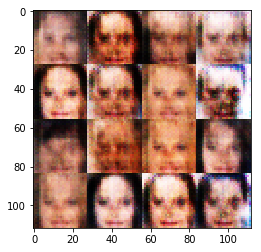

Epoch  0  ... Discri.Loss:  1.25663  Generator loss:  0.937962
Epoch  0  ... Discri.Loss:  1.60901  Generator loss:  0.678111
Epoch  0  ... Discri.Loss:  1.43045  Generator loss:  0.739323
Epoch  0  ... Discri.Loss:  1.34631  Generator loss:  0.780325
Epoch  0  ... Discri.Loss:  1.41061  Generator loss:  0.623807
Epoch  0  ... Discri.Loss:  1.48723  Generator loss:  0.708989
Epoch  0  ... Discri.Loss:  1.37218  Generator loss:  0.746896
Epoch  0  ... Discri.Loss:  1.21742  Generator loss:  0.770372
Epoch  0  ... Discri.Loss:  1.28655  Generator loss:  0.947186
Epoch  0  ... Discri.Loss:  1.58777  Generator loss:  0.591827


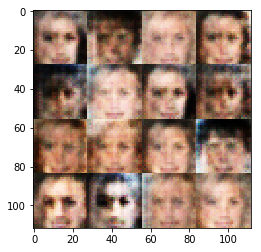

Epoch  0  ... Discri.Loss:  1.44133  Generator loss:  0.865878
Epoch  0  ... Discri.Loss:  1.51355  Generator loss:  0.801262
Epoch  0  ... Discri.Loss:  1.65097  Generator loss:  0.693538
Epoch  0  ... Discri.Loss:  1.29537  Generator loss:  0.686904
Epoch  0  ... Discri.Loss:  1.61856  Generator loss:  0.574077
Epoch  0  ... Discri.Loss:  1.52601  Generator loss:  0.698431
Epoch  0  ... Discri.Loss:  1.32456  Generator loss:  0.810861
Epoch  0  ... Discri.Loss:  1.41956  Generator loss:  0.677014
Epoch  0  ... Discri.Loss:  1.25192  Generator loss:  0.810718
Epoch  0  ... Discri.Loss:  1.37617  Generator loss:  0.748648


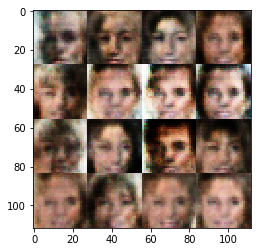

Epoch  0  ... Discri.Loss:  1.28345  Generator loss:  0.880517
Epoch  0  ... Discri.Loss:  1.39271  Generator loss:  0.761528
Epoch  0  ... Discri.Loss:  1.57198  Generator loss:  0.69564
Epoch  0  ... Discri.Loss:  1.56412  Generator loss:  0.750286
Epoch  0  ... Discri.Loss:  1.62862  Generator loss:  0.678537
Epoch  0  ... Discri.Loss:  1.39039  Generator loss:  0.817563
Epoch  0  ... Discri.Loss:  1.39198  Generator loss:  0.801097
Epoch  0  ... Discri.Loss:  1.37276  Generator loss:  0.862981
Epoch  0  ... Discri.Loss:  1.36779  Generator loss:  0.868087
Epoch  0  ... Discri.Loss:  1.33901  Generator loss:  0.743119


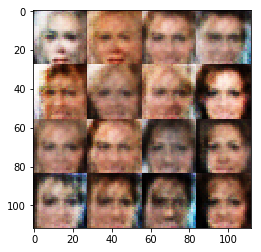

Epoch  0  ... Discri.Loss:  1.37781  Generator loss:  0.798328
Epoch  0  ... Discri.Loss:  1.50434  Generator loss:  0.77952
Epoch  0  ... Discri.Loss:  1.32338  Generator loss:  0.853162
Epoch  0  ... Discri.Loss:  1.47235  Generator loss:  0.700698
Epoch  0  ... Discri.Loss:  1.42173  Generator loss:  0.727309
Epoch  0  ... Discri.Loss:  1.39545  Generator loss:  0.706314
Epoch  0  ... Discri.Loss:  1.29056  Generator loss:  0.94315
Epoch  0  ... Discri.Loss:  1.41069  Generator loss:  0.763668
Epoch  0  ... Discri.Loss:  1.36674  Generator loss:  0.787026
Epoch  0  ... Discri.Loss:  1.36143  Generator loss:  0.81469


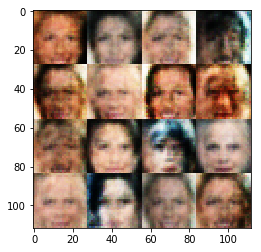

Epoch  0  ... Discri.Loss:  1.31536  Generator loss:  0.803438
Epoch  0  ... Discri.Loss:  1.42413  Generator loss:  0.697722
Epoch  0  ... Discri.Loss:  1.36266  Generator loss:  0.774375
Epoch  0  ... Discri.Loss:  1.36098  Generator loss:  0.919947
Epoch  0  ... Discri.Loss:  1.45324  Generator loss:  0.755583
Epoch  0  ... Discri.Loss:  1.37579  Generator loss:  0.805456
Epoch  0  ... Discri.Loss:  1.40774  Generator loss:  0.74977
Epoch  0  ... Discri.Loss:  1.48791  Generator loss:  0.70529
Epoch  0  ... Discri.Loss:  1.47225  Generator loss:  0.749055
Epoch  0  ... Discri.Loss:  1.40773  Generator loss:  0.722124


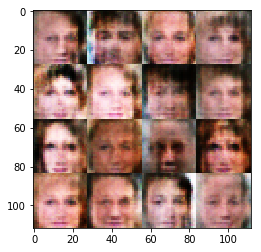

Epoch  0  ... Discri.Loss:  1.37988  Generator loss:  0.908859
Epoch  0  ... Discri.Loss:  1.31292  Generator loss:  0.925194
Epoch  0  ... Discri.Loss:  1.44401  Generator loss:  0.800601
Epoch  0  ... Discri.Loss:  1.54479  Generator loss:  0.759645
Epoch  0  ... Discri.Loss:  1.38899  Generator loss:  0.851861
Epoch  0  ... Discri.Loss:  1.6027  Generator loss:  0.725911
Epoch  0  ... Discri.Loss:  1.50644  Generator loss:  0.812274
Epoch  0  ... Discri.Loss:  1.42527  Generator loss:  0.718195
Epoch  0  ... Discri.Loss:  1.54828  Generator loss:  0.679298
Epoch  0  ... Discri.Loss:  1.43706  Generator loss:  0.695745


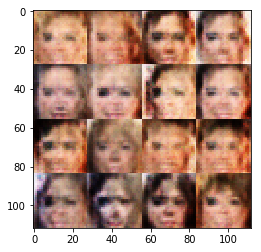

Epoch  0  ... Discri.Loss:  1.44333  Generator loss:  0.740926
Epoch  0  ... Discri.Loss:  1.38246  Generator loss:  0.728004
Epoch  0  ... Discri.Loss:  1.35057  Generator loss:  0.769372
Epoch  0  ... Discri.Loss:  1.41908  Generator loss:  0.79722
Epoch  0  ... Discri.Loss:  1.41193  Generator loss:  0.832962
Epoch  0  ... Discri.Loss:  1.35523  Generator loss:  0.73606
Epoch  0  ... Discri.Loss:  1.44281  Generator loss:  0.763478
Epoch  0  ... Discri.Loss:  1.41887  Generator loss:  0.806099
Epoch  0  ... Discri.Loss:  1.44885  Generator loss:  0.606733
Epoch  0  ... Discri.Loss:  1.41372  Generator loss:  0.781812


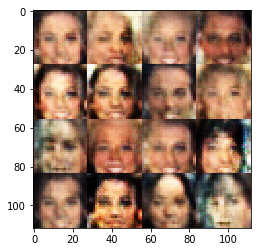

Epoch  0  ... Discri.Loss:  1.39856  Generator loss:  0.755
Epoch  0  ... Discri.Loss:  1.43771  Generator loss:  0.770579
Epoch  0  ... Discri.Loss:  1.39542  Generator loss:  0.813894
Epoch  0  ... Discri.Loss:  1.35365  Generator loss:  0.768579
Epoch  0  ... Discri.Loss:  1.34406  Generator loss:  0.81774
Epoch  0  ... Discri.Loss:  1.42578  Generator loss:  0.750836
Epoch  0  ... Discri.Loss:  1.45365  Generator loss:  0.762486
Epoch  0  ... Discri.Loss:  1.41065  Generator loss:  0.768505
Epoch  0  ... Discri.Loss:  1.44612  Generator loss:  0.662028
Epoch  0  ... Discri.Loss:  1.50058  Generator loss:  0.711858


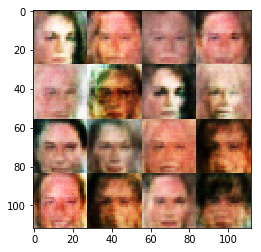

Epoch  0  ... Discri.Loss:  1.46005  Generator loss:  0.671201
Epoch  0  ... Discri.Loss:  1.34068  Generator loss:  0.821147
Epoch  0  ... Discri.Loss:  1.35995  Generator loss:  0.777444
Epoch  0  ... Discri.Loss:  1.36222  Generator loss:  0.769812
Epoch  0  ... Discri.Loss:  1.38322  Generator loss:  0.791017
Epoch  0  ... Discri.Loss:  1.51065  Generator loss:  0.766351
Epoch  0  ... Discri.Loss:  1.5  Generator loss:  0.676838
Epoch  0  ... Discri.Loss:  1.40572  Generator loss:  0.80113
Epoch  0  ... Discri.Loss:  1.47577  Generator loss:  0.66793
Epoch  0  ... Discri.Loss:  1.41859  Generator loss:  0.820566


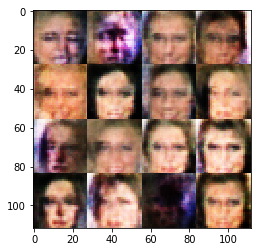

Epoch  0  ... Discri.Loss:  1.39547  Generator loss:  0.854038
Epoch  0  ... Discri.Loss:  1.34541  Generator loss:  0.772655
Epoch  0  ... Discri.Loss:  1.3687  Generator loss:  0.822985
Epoch  0  ... Discri.Loss:  1.47926  Generator loss:  0.645642
Epoch  0  ... Discri.Loss:  1.47264  Generator loss:  0.685442
Epoch  0  ... Discri.Loss:  1.34942  Generator loss:  0.944638
Epoch  0  ... Discri.Loss:  1.4675  Generator loss:  0.715841
Epoch  0  ... Discri.Loss:  1.41452  Generator loss:  0.772875


In [54]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.